In [1]:
import numpy as np
import netCDF4
%matplotlib widget
from matplotlib import pyplot
import ipywidgets

In [2]:
REF_FILE = "SOM/daily_surface_climatology_2007_2016.nc"
#EXP_FILE = "gotm-arctic.nc"
EXP_FILE = "gotm-arctic_split.nc"
REF_NAME, EXP_NAME = "temp", "temp"
vmin_fixed, vmax_fixed = 0.0, 12.0

#REF_NAME, EXP_NAME = "ECO_diac", "ECO_diachl"
#REF_NAME, EXP_NAME = "ECO_flac", "ECO_flachl"
#vmin_fixed, vmax_fixed = 0.0, 5.0

In [3]:
with netCDF4.Dataset(EXP_FILE) as nc:
    cluster_index = nc["cluster_index"][:, :]
    x_ = nc["x_"][:, :]
    y_ = nc["y_"][:, :]
    x = nc["x"][0, :]
    y = nc["y"][0, :]

117 clusters


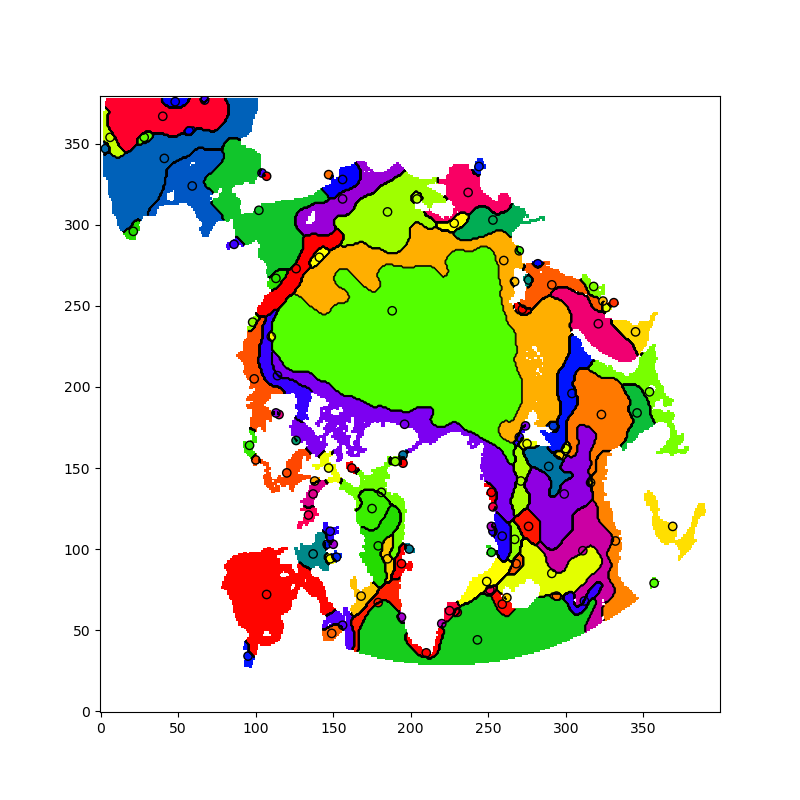

In [4]:
fig, ax = pyplot.subplots(figsize=(8,8))
ax.pcolormesh(x_, y_, cluster_index, cmap="prism")
ax.contour(x_, y_, cluster_index, np.arange(cluster_index.max() + 1), colors='k', linewidths=0.5)
ax.scatter(x, y, c=np.arange(len(x)), cmap="prism", ec='k');
fig.savefig("clusters.png", dpi=150)
print(f"{x.size} clusters")

interactive(children=(IntSlider(value=0, description='itime', max=364), Output()), _dom_classes=('widget-inter…

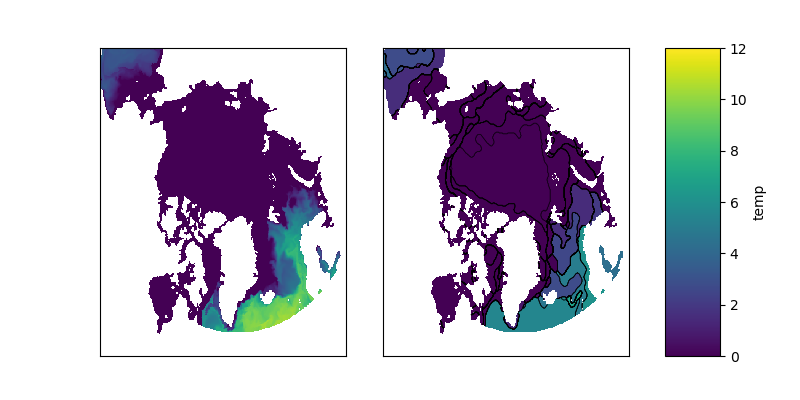

In [5]:
with netCDF4.Dataset(EXP_FILE) as nc:
    x = nc["x_"][:, :]
    y = nc["y_"][:, :]
    cluster_index = nc["cluster_index"][:, :]
    times = netCDF4.num2date(nc["time"], nc["time"].units)

fig, ((ax0, ax1, cax),) = pyplot.subplots(ncols=3, width_ratios=(0.45, 0.45, 0.1), figsize=(8,4), squeeze=False)

exp_offset = 365 - len(times)
def plot(itime=-1):
    with netCDF4.Dataset(REF_FILE) as nc:
        values_ref = nc[REF_NAME][itime, 0, :, :]
        #values_ref = nc[REF_NAME][0, :, :]  # this for REF_FILE==glodap_ip.nc
        values_ref= np.ma.array(values_ref, mask=cluster_index.mask)
    with netCDF4.Dataset(EXP_FILE) as nc:
        values_exp = nc[EXP_NAME][itime + exp_offset, -1, 0, :]
    vmin = vmin_fixed if vmin_fixed is not None else min(values_ref.min(), values_exp.min())
    vmax = vmax_fixed if vmax_fixed is not None else max(values_ref.max(), values_exp.max())
    ax0.cla()
    ax1.cla()
    cax.cla()
    pc = ax0.pcolormesh(x, y, values_ref, vmin=vmin, vmax=vmax)
    values_exp_unpacked = np.ma.array(values_exp[cluster_index], mask=cluster_index.mask)
    pc = ax1.pcolormesh(x, y, values_exp_unpacked, vmin=vmin, vmax=vmax)
    ax1.contour(x_, y_, cluster_index, np.arange(cluster_index.max() + 1), colors='k', linewidths=0.2)
    fig.colorbar(pc, cax=cax)
    ax0.xaxis.set_ticks(())
    ax0.yaxis.set_ticks(())
    ax1.xaxis.set_ticks(())
    ax1.yaxis.set_ticks(())
    cb = fig.colorbar(pc, cax=cax)
    cb.set_label(REF_NAME)

ipywidgets.interact(plot, itime=(0, 364));

interactive(children=(IntSlider(value=58, description='icluster', max=116), Output()), _dom_classes=('widget-i…

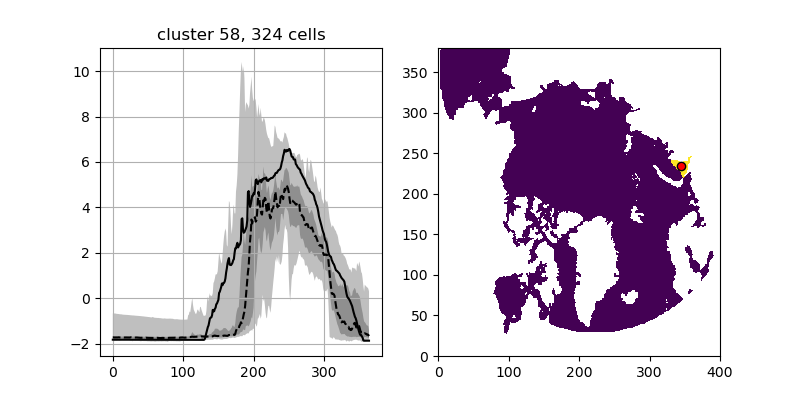

In [6]:
fig_ts, (ax_ts, ax_cluster) = pyplot.subplots(ncols=2, figsize=(8, 4))

with netCDF4.Dataset(EXP_FILE) as nc:
    cluster_x = nc["x"][0, :]
    cluster_y = nc["y"][0, :]
    values_exp = nc[EXP_NAME][slice(-365, None), -1, 0, :]
times = np.arange(values_exp.shape[0])
if REF_FILE is not None:
    with netCDF4.Dataset(REF_FILE) as nc:
        values_ref = nc[REF_NAME][:, 0, :, :]

def plot_timeseries(icluster):
    ax_ts.cla()
    mask = cluster_index == icluster
    ncells = mask.sum()
    if REF_FILE is not None:
        cluster_values_ref = np.asarray(values_ref[:, mask])
        (perc25, median, perc75) = np.percentile(cluster_values_ref, (25, 50, 75), axis=-1)
        min_ref = cluster_values_ref.min(axis=-1)
        max_ref = cluster_values_ref.max(axis=-1)
        if ncells > 1:
            ax_ts.fill_between(times, min_ref, max_ref, fc='k', alpha=0.25)
            ax_ts.fill_between(times, perc25, perc75, fc='k', alpha=0.25)
        ax_ts.plot(times, median, '--k')
    ax_ts.plot(times, values_exp[:, icluster], '-k')
    ax_ts.set_title(f"cluster {icluster}, {ncells} cells")
    ax_ts.grid()
    ax_cluster.cla()
    ax_cluster.pcolormesh(mask)
    ax_cluster.plot([cluster_x[icluster]], [cluster_y[icluster]], 'or', mec='k')

ipywidgets.interact(plot_timeseries, icluster=(0, cluster_x.size - 1));
